In [1]:
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random
import argparse
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# import data_generation as dg

In [2]:
def visualize_dag(csv_path):
    adj_matrix = np.loadtxt(csv_path, delimiter=',')
    """Visualize the DAG using networkx and matplotlib"""
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)  
    pos = nx.spring_layout(G, k= 1.5)  
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1000, arrows=True)
    plt.title("DAG Visualization")
    plt.show()

def visualize_matrix(csv_path):
    adj_matrix = np.loadtxt(csv_path, delimiter=',')
    plt.figure(figsize=(5, 5))
    sns.heatmap(adj_matrix, annot=True, cmap='Blues', cbar=False)
    plt.gca().xaxis.set_label_position('top') 
    plt.gca().xaxis.tick_top()  
    plt.title('Adjacency Matrix Visualization')
    plt.show()

In [3]:
data_path = '/home/jina/reprod/data/train/002'
adj_path = '/home/jina/reprod/data/train/002/B_true_ER_mlp.csv'
x_path = '/home/jina/reprod/data/train/002/X_ER_mlp.csv'

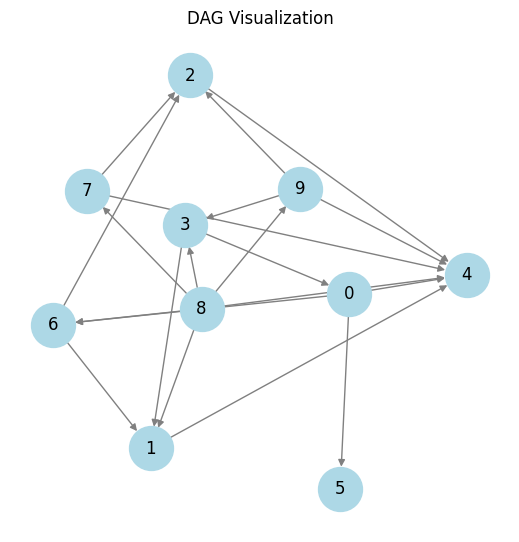

In [4]:
visualize_dag(adj_path)

In [5]:
import pickle

pk = '/home/jina/reprod/data/pickle/simple2'
with open(pk, 'rb') as f:
    data = pickle.load(f)

# pk_v = '/home/jina/reprod/data/pickle/simple_test'
# with open(pk_v, 'rb') as f:
#     valid_data = pickle.load(f)

In [6]:
len(data)

3000

In [7]:
# train-test split
train_idx = random.sample(range(3000), 2000)
valid_idx = [i for i in range(3000) if i not in train_idx]
# print(len(train_idx))
train_data = [data[i] for i in train_idx]
valid_data = [data[i] for i in valid_idx]

In [8]:
len(train_data), len(valid_data)

(2000, 1000)

- model

In [9]:
import math

import numpy as np
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F


class CustomSAGEConv(SAGEConv):
    def __init__(self, node_dim, edge_dim, aggr='mean', normalize=True, root_weight=True, bias=True, device='cpu'):
        super(CustomSAGEConv, self).__init__(node_dim, edge_dim)
        self.relu = nn.ReLU()
        self.aggr = aggr
        self.normalize = normalize
        self.root_weight = root_weight
        self.bias = bias
        self.device = device
        if self.root_weight:
            weight_dim = 3*node_dim + edge_dim
        else:
            weight_dim = 2*node_dim + edge_dim
        self.lin = nn.Linear(weight_dim, node_dim, bias=self.bias)
        # nn.init.xavier_normal_(self.lin.weight)


    def forward(self, x, edge_index, edge_features, num_nodes, num_neighbor=None):
        v = edge_index[0, :]
        u = edge_index[1, :]
        v_node_features = x[v]
        u_node_features = x[u]

        message = torch.cat([v_node_features, u_node_features, edge_features], dim=-1).to(self.device)
        message_dim = message.size(1)
        node_messages = torch.zeros((num_nodes, message_dim), device=self.device)

        # 이웃 샘플링 (num_neighbor가 설정되어 있을 때만)
        if num_neighbor is not None:
            # 각 노드에 대해 이웃을 샘플링
            unique_v, counts_v = torch.unique(v, return_counts=True)  # 각 노드의 이웃 수 계산
            # unique_u, counts_u = torch.unique(u, return_counts=True)

            sampled_edges = []
            for node, count in zip(unique_v, counts_v):
                neighbors_idx = (v == node).nonzero(as_tuple=False).squeeze()

                if neighbors_idx.dim() == 0:  # 이웃이 없는 경우에 대비한 처리
                    neighbors_idx = neighbors_idx.unsqueeze(0)

                if count > num_neighbor:  # 이웃이 num_neighbor보다 많은 경우
                    sampled_neighbors = neighbors_idx[torch.randperm(neighbors_idx.size(0))[:num_neighbor]]
                    sampled_edges.append(sampled_neighbors)
                else:
                    sampled_edges.append(neighbors_idx)

            # 1차원 이상의 텐서만 연결
            sampled_edges = [edge for edge in sampled_edges if edge.numel() > 0]
            sampled_edges = torch.cat(sampled_edges)

            v = v[sampled_edges]
            u = u[sampled_edges]
            message = message[sampled_edges]

        if self.aggr == 'mean':
            node_messages = node_messages.index_add(0, v, message.float())
            node_messages = node_messages.index_add(0, u, message.float())
            if num_neighbor:
               num_neighbors = torch.bincount(v, minlength=num_nodes).clamp(max=num_neighbor) \
                + torch.bincount(u, minlength=num_nodes).clamp(max=num_neighbor)
            else: 
                num_neighbors = torch.bincount(v, minlength=num_nodes) + torch.bincount(u, minlength=num_nodes)
            node_messages /= (num_neighbors.unsqueeze(1) + 1e-6)

        if self.root_weight:
            out = torch.cat([x, node_messages], dim=-1).to(self.device)
        else:
            out = node_messages

        out = self.lin(out.float())
        # out = self.relu(out)

        # 선택적 정규화 적용
        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class customGraphSAGE(nn.Module):

    def __init__(self, node_dim, edge_dim, num_layers,
                 agg_class='mean', dropout=0.5, num_samples=3, output_class = 2,
                 device='cpu'):
        super().__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.agg_class = agg_class
        self.num_samples = num_samples
        self.device = device
        self.num_layers = num_layers

        self.conv1 = CustomSAGEConv(node_dim, edge_dim, device=self.device)
        self.mlp = nn.Sequential(nn.Linear(2 * node_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(),
                    nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 1),  
                    )
        
        self.bns = nn.BatchNorm1d(node_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_features = data.edge_attr
        num_nodes = data.num_nodes

        for k in range(self.num_layers):
            x = self.conv1(x, edge_index, edge_features, num_nodes, num_neighbor=self.num_samples)
            x = self.dropout(x)
            x = self.relu(x)
        
        v = edge_index[0, :]
        u = edge_index[1, :]
        v_node_embedding = x[v]  
        u_node_embedding = x[u]  

        pair_embedding = torch.cat([v_node_embedding, u_node_embedding], dim=-1)
        self.pred = self.mlp(pair_embedding)  # MLP를 통해 예측 
        # pred = F.log_softmax(pred, dim=1)
        return self.pred
    
    def predict_adjacency_matrix(self, num_nodes, edge_index, threshold):
        B_pred = torch.zeros((num_nodes, num_nodes), device=self.device)
        edge_prob = (torch.sigmoid(self.pred) > threshold).float()
        for i, edge in enumerate(edge_index.t()):
            if edge_prob[i] == 1:  # Forward edge
                B_pred[edge[0], edge[1]] = 1
                B_pred[edge[1], edge[0]] = 1


In [ ]:

for i, edge in enumerate(edge_index.t()):
    print(i, edge)
    break

In [11]:
# Random seed setting
def seed_everything(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [12]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
from collections import Counter

batch_size = 32
epochs = 30
num_layers = 5
lr = 0.0001
num_neighbor = None
threshold = 0.5
# seed_everything(47)
seed_everything(11)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

loader_type = {
    "train": train_loader,
    "test": valid_loader
}

node_dim = train_data[0].x.size(1)
edge_dim = train_data[0].edge_attr.size(1)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
custom_model = customGraphSAGE(node_dim, edge_dim, num_layers=num_layers, output_class=2, device=device, num_samples=num_neighbor).to(device)
optimizer = torch.optim.Adam(custom_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


best_test_f1 = 0
best_test_acc = 0
best_test_loss = 9999


for epoch in range(epochs):

    for mode in ["train", "test"]:
        running_loss = 0
        running_acc = 0
        total_samples = 0

        if mode == "train":
            custom_model.train()
            train_predictions = []
            train_labels = []
        elif mode == "test":
            custom_model.eval()
            test_predictions = []
            test_labels = []
        
        for data in loader_type[mode]:
            data.x = data.x.float()
            data.y = data.y.long()

            data.y[data.y == 2] = 1
            data = data.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(mode == "train"):
                logits = custom_model(data)
                preds = (torch.sigmoid(logits) > threshold).float()
                loss = nn.BCEWithLogitsLoss()(logits, data.y.view(-1, 1).float())

                if mode == "train":
                    loss.backward()
                    optimizer.step()

                    train_predictions.extend(preds.cpu().numpy())
                    train_labels.extend(data.y.cpu().numpy())

                elif mode == "test":
                    test_predictions.extend(preds.cpu().numpy())
                    test_labels.extend(data.y.cpu().numpy())  

            running_loss += loss.item() * data.y.size(0)
            running_acc += torch.sum(preds.squeeze() == data.y).item()
            total_samples += data.y.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_acc / total_samples

        if mode == "train":
            epoch_f1 = f1_score(train_labels, train_predictions, average='binary')
            scheduler.step(epoch_loss)
        elif mode == "test":
            epoch_f1 = f1_score(test_labels, test_predictions, average='binary')
            # scheduler.step(epoch_loss)

        print(f'epoch: {epoch+1}, {mode} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f} f1: {epoch_f1:.3f}')

        if mode == "test" and best_test_f1 < epoch_f1:
            best_test_f1 = epoch_f1

        if mode == "test" and best_test_acc < epoch_acc:
            best_test_acc = epoch_acc

        if mode == "test" and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss

print("training end!!")
print(f"best f1: {best_test_f1}, best acc: {best_test_acc}, best loss: {best_test_loss}")

epoch: 1, train loss: 0.673, acc: 0.686 f1: 0.562
epoch: 1, test loss: 0.632, acc: 0.927 f1: 0.922
epoch: 2, train loss: 0.557, acc: 0.910 f1: 0.907
epoch: 2, test loss: 0.422, acc: 0.974 f1: 0.974
epoch: 3, train loss: 0.319, acc: 0.950 f1: 0.950
epoch: 3, test loss: 0.167, acc: 0.982 f1: 0.982
epoch: 4, train loss: 0.171, acc: 0.957 f1: 0.957
epoch: 4, test loss: 0.080, acc: 0.986 f1: 0.986
epoch: 5, train loss: 0.115, acc: 0.971 f1: 0.971
epoch: 5, test loss: 0.048, acc: 0.988 f1: 0.988
epoch: 6, train loss: 0.104, acc: 0.971 f1: 0.971
epoch: 6, test loss: 0.045, acc: 0.990 f1: 0.990
epoch: 7, train loss: 0.090, acc: 0.976 f1: 0.976
epoch: 7, test loss: 0.036, acc: 0.992 f1: 0.992
epoch: 8, train loss: 0.079, acc: 0.979 f1: 0.979
epoch: 8, test loss: 0.029, acc: 0.993 f1: 0.993
epoch: 9, train loss: 0.088, acc: 0.978 f1: 0.978
epoch: 9, test loss: 0.037, acc: 0.992 f1: 0.992
epoch: 10, train loss: 0.078, acc: 0.979 f1: 0.979
epoch: 10, test loss: 0.024, acc: 0.994 f1: 0.994
epoch: 1

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 정확도 계산
accuracy = accuracy_score(test_labels, test_predictions)

# F1 점수 계산 (binary classification이므로 average='binary')
f1 = f1_score(test_labels, test_predictions)

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions).ravel()

# 결과 출력
print(f"Accuracy: {accuracy:}")
print(f"F1 Score: {f1:}")
print("Confusion Matrix:")
print(tn, fp, fn, tp)


Accuracy: 0.998
F1 Score: 0.9980119284294234
Confusion Matrix:
496 0 2 502


- test

In [14]:
import pickle

pk_t = '/home/jina/reprod/data/pickle/simple_test'
with open(pk_t, 'rb') as f:
    test_data = pickle.load(f)

In [16]:

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
from collections import Counter

batch_size = 1
epochs = 1
num_layers = 5
lr = 0.0001
num_neighbor = 2
threshold = 0.5
# seed_everything(47)
seed_everything(11)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

loader_type = {
    # "train": train_loader,
    "test": test_loader
}

node_dim = test_data[0].x.size(1)
edge_dim = test_data[0].edge_attr.size(1)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# custom_model = customGraphSAGE(node_dim, edge_dim, num_layers=num_layers, output_class=2, device=device, num_samples=None).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)


best_test_f1 = 0
best_test_acc = 0
best_test_loss = 9999


for epoch in range(epochs):

    for mode in ["test"]:
        running_loss = 0
        running_acc = 0
        total_samples = 0
        all_predictions = []
        all_labels = []

        custom_model.eval()
        
        for data in loader_type[mode]:
         
            data.x = data.x.float()
            data.y = data.y.long()

            data.y[data.y == 2] = 1
            data = data.to(device)

            # optimizer.zero_grad()

            with torch.no_grad():
                logits = custom_model(data)
                preds = (torch.sigmoid(logits) > threshold).float()
                loss = nn.BCEWithLogitsLoss()(logits, data.y.view(-1, 1).float())

                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(data.y.cpu().numpy())

            running_loss += loss.item() * data.y.size(0)
            running_acc += torch.sum(preds.squeeze() == data.y).item()
            total_samples += data.y.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_acc / total_samples
        epoch_f1 = f1_score(all_labels, all_predictions, average='binary')
        print(f'epoch: {epoch+1}, {mode} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f} f1: {epoch_f1:.3f}')

        if mode == 'test' and best_test_f1 < epoch_f1:
            best_test_f1 = epoch_f1

        if mode == 'test' and best_test_acc < epoch_acc:
            best_test_acc = epoch_acc

        if mode == 'test' and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss

# print("training end!!")
# print(f"best f1: {best_test_f1}, best acc: {best_test_acc}, best loss: {best_test_loss}")

epoch: 1, test loss: 0.026, acc: 0.992 f1: 0.992


In [17]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 정확도 계산
accuracy = accuracy_score(all_labels, all_predictions)

# F1 점수 계산 (binary classification이므로 average='binary')
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

# 결과 출력
print(f"Accuracy: {accuracy:}")
print(f"F1 Score: {f1:}")
print("Confusion Matrix:")
print(tn, fp, fn, tp)

Accuracy: 0.992
F1 Score: 0.9920529801324504
Confusion Matrix:
739 5 7 749


- adjacency matrix 만들고 원래 그래프와 비교

In [18]:
all_labels

[np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.in

In [19]:
all_predictions

[array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], d

In [20]:
all_labels_flat = torch.cat([torch.tensor(batch).unsqueeze(0) if torch.tensor(batch).dim() == 0 else torch.tensor(batch)
                             for batch in all_labels], dim=0).numpy()

all_labels_flat

array([0, 1, 0, ..., 1, 0, 0])

In [21]:
all_predictions_flat = torch.cat([torch.tensor(batch).unsqueeze(0) if torch.tensor(batch).dim() == 0 else torch.tensor(batch)
                                  for batch in all_predictions], dim=0).numpy()

all_predictions_flat

array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)

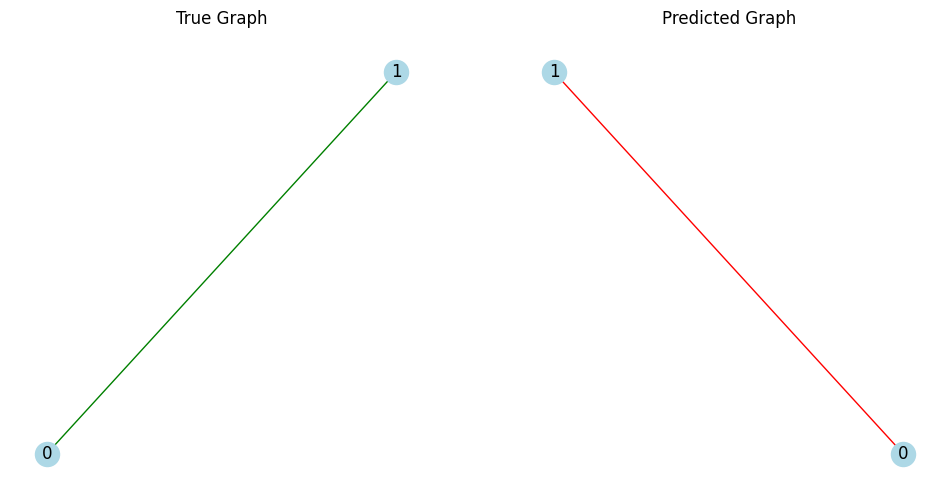

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Flatten all_labels and all_predictions into tensors
all_labels_flat = torch.cat([torch.tensor(batch).unsqueeze(0) if torch.tensor(batch).dim() == 0 else torch.tensor(batch)
                             for batch in all_labels], dim=0).numpy()

all_predictions_flat = torch.cat([torch.tensor(batch).unsqueeze(0) if torch.tensor(batch).dim() == 0 else torch.tensor(batch)
                                  for batch in all_predictions], dim=0).numpy()

# 복원 작업: 각 데이터 배치에서 edge_index를 추출하고 매칭
reconstructed_true_graph = nx.Graph()
reconstructed_predicted_graph = nx.Graph()

for batch_data in test_loader:
    edge_index = batch_data.edge_index.cpu().numpy()  # (2, num_edges)
    num_edges = edge_index.shape[1]
    
    # Slice all_labels_flat and all_predictions_flat for the current batch
    batch_labels = all_labels_flat[:num_edges]
    batch_predictions = all_predictions_flat[:num_edges]
    
    # Remove processed edges from the flat arrays
    all_labels_flat = all_labels_flat[num_edges:]
    all_predictions_flat = all_predictions_flat[num_edges:]
    
    # Add edges to the true graph
    for i, edge in enumerate(edge_index.T):  # edge_index.T gives edge pairs as (source, target)
        if batch_labels[i] == 1:  # If label indicates an edge exists
            reconstructed_true_graph.add_edge(edge[0], edge[1])

    # Add edges to the predicted graph
    for i, edge in enumerate(edge_index.T):
        if batch_predictions[i] == 1:  # If prediction indicates an edge exists
            reconstructed_predicted_graph.add_edge(edge[0], edge[1])

# Visualization
plt.figure(figsize=(12, 6))

# True graph visualization
plt.subplot(1, 2, 1)
nx.draw(reconstructed_true_graph, with_labels=True, node_color='lightblue', edge_color='green')
plt.title("True Graph")

# Predicted graph visualization
plt.subplot(1, 2, 2)
nx.draw(reconstructed_predicted_graph, with_labels=True, node_color='lightblue', edge_color='red')
plt.title("Predicted Graph")

plt.show()


In [ ]:
# Forward pass to get node embeddings
data = test_data[0].to(device)  # Example test data
node_embeddings = custom_model(data)

# Predict adjacency matrix
num_nodes = data.num_nodes
B_binary, B_pred = custom_model.predict_adjacency_matrix(node_embeddings, num_nodes)

# 결과 확인
print("Predicted Binary Adjacency Matrix:")
print(B_binary.cpu().numpy())

print("Predicted Probabilistic Adjacency Matrix:")
print(B_pred.cpu().detach().numpy())


In [7]:
adj_array = np.loadtxt(adj_path, delimiter=',')
true_adj = torch.from_numpy(adj_array)
num_nodes = true_adj.size(0)

x_pd = pd.read_csv(x_path)

In [8]:
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()

In [9]:
true_adj

tensor([[0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [10]:
true_adj[0][5]

tensor(1., dtype=torch.float64)

In [11]:
edge_index.shape

torch.Size([2, 45])

In [12]:
edge_exist = torch.nonzero(true_adj, as_tuple=False).t().contiguous()
# edge_label = torch.zeros(edge_index.size(1)) 
edge_exist

tensor([[0, 0, 0, 1, 2, 3, 3, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9],
        [4, 5, 6, 4, 4, 0, 1, 1, 2, 2, 4, 1, 3, 4, 6, 7, 9, 2, 3, 4]])

In [13]:
edge_label = torch.zeros(edge_index.size(1)) 
for i, edge in enumerate(edge_index.t()):
    if (edge == edge_exist.t()).all(1).any():
        edge_label[i] = 1
    elif (edge.flip(0) == edge_exist.t()).all(1).any():
        edge_label[i] = 2

In [14]:
edge_label

tensor([0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 2., 0., 2., 0., 0.,
        1., 0., 2., 2., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 2., 2., 2., 0.,
        0., 0., 0., 0., 2., 0., 2., 0., 1.])

In [15]:
import feature_extract as fe

node_features = torch.from_numpy(np.nan_to_num(fe.extract_node_features(x_pd), nan=0.0))
edge_features = torch.from_numpy(np.nan_to_num(fe.extract_edge_features(x_pd), nan=0.0))


In [21]:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=edge_label, num_nodes=num_nodes)


In [17]:
data.y

tensor([0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 2., 1., 0., 2., 0., 2., 0., 0.,
        1., 0., 2., 2., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 2., 2., 2., 0.,
        0., 0., 0., 0., 2., 0., 2., 0., 1.])

In [56]:
data.y[data.y==2]=1

In [57]:
pos_edge_index = edge_index[:, data.y == 1]
neg_edge_index = edge_index[:, data.y == 0]

In [58]:
pos_edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 6, 7, 8],
        [3, 4, 5, 6, 3, 4, 6, 8, 4, 6, 7, 9, 8, 9, 7, 8, 9, 8, 8, 9]])

In [59]:
neg_edge_index

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6,
         7],
        [1, 2, 7, 8, 9, 2, 5, 7, 9, 3, 5, 8, 4, 5, 6, 7, 5, 6, 6, 7, 8, 9, 7, 9,
         9]])

In [60]:
data.x.shape

torch.Size([10, 11])

In [ ]:
z = data.x
z_product = torch.sum(z[edge_index[0]] * z[edge_index[1]], dim=1)
z_product / (torch.norm(z[edge_index[0]], dim=1) * torch.norm(z[edge_index[1]], dim=1) + 1e-6)  


In [25]:
data

Data(x=[10, 11], edge_index=[2, 45], edge_attr=[45, 100], y=[45], num_nodes=10)

In [26]:
from torch_geometric.nn.models import AttentiveFP

In [20]:
# 데이터셋 생성 (샘플 그래프)
# 노드의 특징과 엣지 정보를 정의합니다.
x = torch.tensor([[1, 0], [0, 1], [1, 1], [0, 0]], dtype=torch.float)  # 노드 특징 (4개의 노드, 각 2차원 특징)
edge_index = torch.tensor([[0, 1, 2, 3], [1, 0, 3, 2]], dtype=torch.long)  # 엣지 (양방향)

# Feature engineering: 논문 기반의 노드 및 엣지 특성 추출
# 노드 특성: 최대값, 최소값, 정규화된 엔트로피, 왜도, 첨도 등을 포함한 통계적 특성
x_np = x.numpy()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_np)  # 표준화 수행

# 통계적 특징 계산 (예: 최대값, 최소값, 평균, 엔트로피, 왜도, 첨도 등)
x_mean = np.mean(x_scaled, axis=1, keepdims=True)
x_max = np.max(x_scaled, axis=1, keepdims=True)
x_min = np.min(x_scaled, axis=1, keepdims=True)
x_std = np.std(x_scaled, axis=1, keepdims=True)
x_entropy = np.apply_along_axis(lambda row: entropy(row + 1e-5), axis=1, arr=x_scaled).reshape(-1, 1)  # 엔트로피 계산
x_skew = skew(x_scaled, axis=1).reshape(-1, 1)  # 왜도 계산
x_kurtosis = kurtosis(x_scaled, axis=1).reshape(-1, 1)  # 첨도 계산

# 기존 특징과 새로운 특징을 결합하여 최종 입력 특징으로 사용
x_combined = np.concatenate([x_scaled, x_mean, x_max, x_min, x_std, x_entropy, x_skew, x_kurtosis], axis=1)
x = torch.tensor(x_combined, dtype=torch.float)

# 엣지 특성 추출: 노드 쌍 간의 상호작용 특징 (예: 유사도, 거리 등)
num_edges = edge_index.size(1)
edge_features = []
for i in range(num_edges):
    src, dst = edge_index[0, i], edge_index[1, i]
    feature_diff = torch.abs(x[src] - x[dst])  # 노드 간의 차이 절대값
    feature_sum = x[src] + x[dst]  # 노드 간의 합
    edge_features.append(torch.cat([feature_diff, feature_sum]))
edge_features = torch.stack(edge_features)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_features)


/tmp/ipykernel_195401/1406310961.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x_skew = skew(x_scaled, axis=1).reshape(-1, 1)  # 왜도 계산
/tmp/ipykernel_195401/1406310961.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x_kurtosis = kurtosis(x_scaled, axis=1).reshape(-1, 1)  # 첨도 계산


In [31]:
# GNN 모델 정의 (MessagePassing을 사용하여 edge_attr 반영)
class CausalGraphSAGE(MessagePassing):
    def __init__(self):
        super(CausalGraphSAGE, self).__init__(aggr='mean')  # 평균 집계를 사용
        self.node_mlp = nn.Sequential(
            nn.Linear(11, 16),  # 노드 특징 차원을 11로 변경
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.edge_mlp = nn.Sequential(
            nn.Linear(18, 8),  # 엣지 특징 차원을 18로 변경 (feature_diff와 feature_sum 합친 차원)
            nn.ReLU(),
            nn.Linear(8, 8)
        )
        self.combine_mlp = nn.Sequential(
            nn.Linear(17, 8),  # 노드와 엣지 특성을 결합한 후 차원을 줄이기 위한 레이어
            nn.ReLU()
        )
        self.fc = nn.Linear(8, 1)  # 최종 예측을 위한 완전 연결 계층
        
    def forward(self, x, edge_index, edge_attr):
        # MessagePassing의 propagate 호출 (노드, 엣지 인덱스, 엣지 특성)
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        x = torch.mean(x, dim=0)  # 노드 특징의 평균을 사용해 그래프 수준의 표현을 만듦
        x = self.fc(x)
        return torch.sigmoid(x)  # 엣지 유무 확률 예측

    def message(self, x_j, edge_attr):
        # 메시지 전달 시 노드 특징과 엣지 특징을 모두 고려
        edge_features = self.edge_mlp(edge_attr)
        combined_features = torch.cat([x_j, edge_features], dim=1)  # 노드와 엣지 특징 결합 (차원을 17로 만듦)
        return self.combine_mlp(combined_features)  # 결합된 특징을 줄여서 반환

In [42]:
# 모델, 손실 함수, 옵티마이저 초기화
model = CausalGraphSAGE()
model.reset_parameters()
criterion = nn.BCEWithLogitsLoss()  # 이진 분류 손실 함수 (logits 사용)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)  # 순방향 계산
    out = out.clamp(min=1e-7, max=1 - 1e-7)  # 출력 값을 안정적인 범위로 제한하여 NaN 방지
    label = torch.tensor([1.0], dtype=torch.float)  # 예시 레이블 (엣지 존재 여부)
    loss = criterion(out, label)  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트

    if epoch % 10 == 0:
        # 정확도 및 F1 점수 계산
        pred_class = torch.sigmoid(out).clamp(min=1e-7, max=1 - 1e-7).round().detach().numpy()
        label_class = label.detach().numpy()
        accuracy = accuracy_score(label_class, pred_class)
        f1 = f1_score(label_class, pred_class)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}, F1 Score: {f1}')

# 예측
model.eval()
pred = model(data.x, data.edge_index, data.edge_attr)
print(f'Predicted edge existence probability: {torch.sigmoid(pred).item()}')

/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_pred contains NaN.